# Project 3 Source Code

## Imports

In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize
from torch.nn.functional import conv2d, pad
import torch
from project2_cuda import corner_nms, ncc, harris_corner
from project3_cuda import disparity_map
from typing import Tuple, Union
from glob import glob
from os.path import join
import matplotlib
import random
import tqdm
import cv2
matplotlib.rcParams['figure.figsize'] = [10, 10]

## Convenience Methods

In [2]:
def read_image(path: str) -> torch.Tensor:
    return torch.tensor(np.array(Image.open(path))).type(torch.float32)

def read_images(paths):
    return [read_image(path) for path in paths]

def get_patch_rads(x, y, patch_rad, r, c):
    patch_x_begin = x if x - patch_rad < 0 else patch_rad
    patch_x_end = r - x if x + patch_rad > r else patch_rad
    patch_y_begin = y if y - patch_rad < 0 else patch_rad
    patch_y_end = r - y if y + patch_rad > c else patch_rad
    return patch_x_begin, patch_x_end, patch_y_begin, patch_y_end


def rgb2gray(img: torch.Tensor) -> torch.Tensor:
    """
    Converts an RGB image to Grayscale
    :param img: the RGB image as a pytorch tensor
    :return: The image as grayscale
    """
    return torch.mean(img, dim=2)


def downscale(img: torch.Tensor, factor):
    """
    downscales the size of the given image by the given factor
    :param img: the image as a pytorch Tensor
    :param factor: the factor by which the dimensions of the input
    image will be downsampled by
    :return: the downscaled image as a pytorch Tensor
    """
    r, c = img.size()
    r = r // factor
    c = c // factor
    return resize(img.unsqueeze(0), [r, c]).squeeze()
        
        

def convolve2d(img: Union[np.ndarray, torch.Tensor], weight: Union[np.ndarray, torch.Tensor],
             padding: str = 'same') -> torch.Tensor:
    """
    A convenience function for convolving 2D images with 2D filters using Pytorch 2D convolution.
    Does not alter the device of the tensor, but converts the data type to torch.float32.
    :param img:
    :param weight:
    :param padding:
    :return:
    """
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img).float()
    if isinstance(weight, np.ndarray):
        weight = torch.from_numpy(weight).float()

    assert len(img.shape) == 2 and len(weight.shape) == 2
    assert img.device == weight.device

    img = img.unsqueeze(0).unsqueeze(0)
    weight = weight.unsqueeze(0).unsqueeze(0)
    return conv2d(img, weight, padding=padding).squeeze()

## Noise Removal functions

In [3]:
# Box filter for smoothing
def box_filter(img: Union[np.ndarray, torch.Tensor], diameter: int, padding: str = 'same') -> torch.Tensor:
    """
    Applies box filter to the given image
    :param padding: Padding to be used for filtering
    :param img: Image of interest as a torch.Tensor
    :param diameter: the diameter of the box filter
    :return: filtered image.
    """
    box = torch.ones([diameter, diameter],
                     dtype=torch.float,
                     device=img.device) / diameter**2
    return convolve2d(img, box, padding)

def gaussian_filter(img: Union[np.ndarray, torch.Tensor], s_sigma: float, padding: str = 'same') -> torch.Tensor:
    filt_rad = int(np.floor(5 * s_sigma))
    offset = filt_rad // 2
    g_filt_2d = torch.zeros((filt_rad, filt_rad), dtype=torch.float32, device=img.device)
    for i in range(filt_rad):
        for j in range(filt_rad):
            g_filt_2d[i, j] = np.exp(-((i - offset)**2 + (j - offset)**2) / (2 * s_sigma**2))
    g_filt_2d = g_filt_2d / g_filt_2d.sum()
    return convolve2d(img, g_filt_2d, padding)

## Gradient Estimation Functions

In [4]:
def sobel_x(img: torch.Tensor, padding: str = 'same') -> torch.Tensor:
    """
    Computes the gradient of the image in the x-direction using
    a sobel filter.
    :param padding: padding type to use when applying the filter. Follows the convention of Pytorch padding types
    :param img: image of interest, as a torch.Tensor. Can be
    on both GPU and CPU
    :return: Gradient estimate of the image, as a torch.Tensor,
    on the same device as the img
    """
    sobel_x_filter = torch.tensor([[1., 0., -1.],
                                   [2., 0., -2.],
                                   [1., 0., -1.]], device=img.device)
    return convolve2d(img, sobel_x_filter, padding)


def sobel_y(img: torch.Tensor, padding: str = 'same'):
    """
    Computes the gradient of the image in the y-direction using
    a sobel filter.
    :param img: image of interest, as a torch.Tensor. Can be
    on both GPU and CPU
    :return: Gradient estimate of the image, as a torch.Tensor,
    on the same device as the img
    """
    sobel_y_filter = torch.tensor([[1., 2., 1.],
                                   [0., 0., 0.],
                                   [-1., -2., -1.]
                                   ], device=img.device)
    return convolve2d(img, sobel_y_filter, padding)


def estimate_gradient_dirs(img: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    return sobel_x(img), sobel_y(img)

## Harris Corner Detector Functions

In [5]:
def harris_corner_detector(image, radius, threshold=0.02, k=0.05, sigma=1):
    image = gaussian_filter(image, sigma)
    # Find gradients
    Ix, Iy = estimate_gradient_dirs(image)
    # Apply harris corner detection
    R = harris_corner(Ix, Iy, radius, k)
    
    # Threshold values
    R[R < threshold * torch.max(R)] = 0
    
    # Nonmax Supression
    R = corner_nms(R, radius)

    return R


# Reduce threshold until ~1% of pixels are corners
def reduced_harris(image, radius, k, sigma, target_corner_ratio):
    threshold = 1.
    corner_image_ratio = 0.
    corners = None
    while corner_image_ratio < target_corner_ratio:
        corners = harris_corner_detector(image, radius, threshold, k, sigma)
        corner_image_ratio = (corners > 0).sum() / image.numel()
        threshold = 0.9 * threshold
    return corners

## Image Loading and Pre-processing

In [6]:
cones_files = ['Cones_im2.jpg', 'Cones_im6.jpg']
cast_files = ['cast-left-1.jpg', 'cast-right.jpg']

cones_images = read_images(cones_files)
cast_images = read_images(cast_files)
cones_images = [rgb2gray(img).cuda() for img in cones_images]
cast_images = [rgb2gray(img).cuda() for img in cast_images]

## Harris Corner Detection Stage for Hallway Dataset

Applying Harris Corner Detection to Cast
Number of corners found: 475


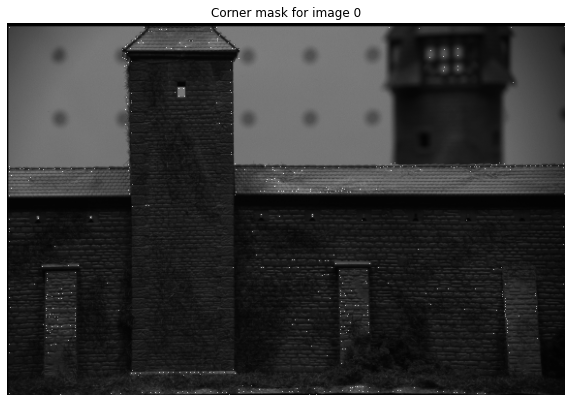

Number of corners found: 482


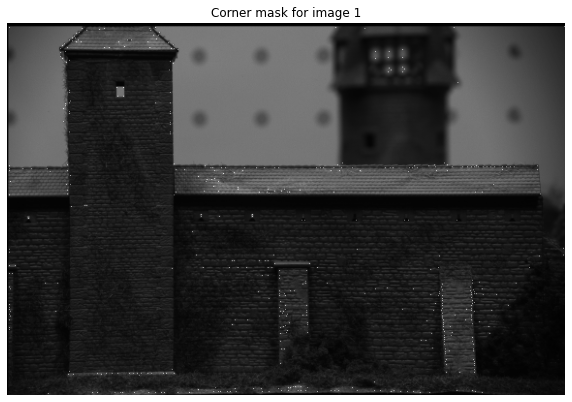

In [7]:
radius = 1
k = 0.04
sigma = 1
target_ratio = 0.002

print("Applying Harris Corner Detection to Cast")
cast_corner_masks = []
for i, img in enumerate(cast_images):
    corner_mask = reduced_harris(img, radius, k, sigma, target_ratio)
    print(f"Number of corners found: {(corner_mask > 0).sum()}")
    fig, ax = plt.subplots()
    ax.imshow(img.cpu().numpy(), cmap='gray')
    ax.imshow(corner_mask.cpu().numpy() > 0, cmap='gray', alpha=0.5)
    ax.set_title(f'Corner mask for image {i}')
    plt.axis('off')
    plt.show()
    cast_corner_masks.append(corner_mask)

### Harris Corner Detection Stage for Cones

Applying Harris Corner Detection to Cones
Number of corners found: 346


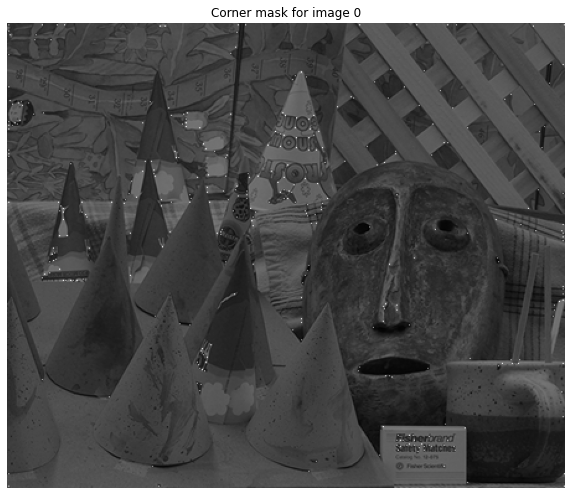

Number of corners found: 361


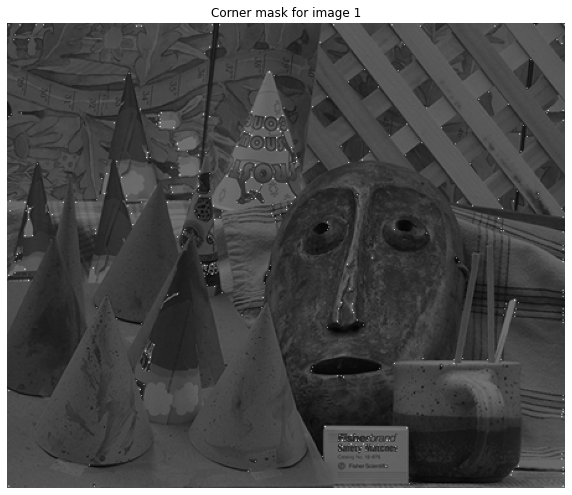

In [8]:
radius = 1
k = 0.04
sigma = 1
target_ratio = 0.002

print("Applying Harris Corner Detection to Cones")
cones_corner_masks = []
for i, img in enumerate(cones_images):
    corner_mask = reduced_harris(img, radius, k, sigma, target_ratio)
    print(f"Number of corners found: {(corner_mask > 0).sum()}")
    fig, ax = plt.subplots()
    ax.imshow(img.cpu().numpy(), cmap='gray')
    ax.imshow(corner_mask.cpu().numpy() > 0, cmap='gray', alpha=0.5)
    ax.set_title(f'Corner mask for image {i}')
    plt.axis('off')
    plt.show()
    cones_corner_masks.append(corner_mask)

### Feature Matching Function

In [9]:
# Normalized Cross Correlation of two equal shaped patches
def patch_ncc(f, g):
    len_f = torch.sqrt(torch.sum(f**2))
    len_g = torch.sqrt(torch.sum(g**2))
    return (f * g).sum() / (len_f * len_g)

# Find matches from im1 to im2
def patch2patch(im1, im2, corner_mask_1, corner_mask_2, radius):
    
    num_corners_1 = (corner_mask_1 > 0).sum()
    num_corners_2 = (corner_mask_2 > 0).sum()
    num_matches = min(num_corners_1, num_corners_2)
    
    # Patch from location
    def get_patch(im, x, y, radius):
        return im[x - radius: x + radius + 1,
               y - radius: y + radius + 1]

    def corner_coord(corner_mask):
        corner_coords = torch.where(corner_mask > 0)
        corner_coords = torch.stack(corner_coords).T.cpu()
        return corner_coords

    # Find patch coordinates
    corner_coords_1 = corner_coord(corner_mask_1)
    corner_coords_2 = corner_coord(corner_mask_2)

    matches = torch.zeros([num_matches, 5], dtype=torch.float32)
    
    for i in range(num_matches):
        x_1 = corner_coords_1[i, 0]
        y_1 = corner_coords_1[i, 1]
  
        # Match the patch to second image
        patch1 = get_patch(im1, x_1, y_1, radius)
        best_match = torch.tensor([x_1, y_1, 0, 0, 0.])
        for j in range(corner_coords_2.shape[0]):
            x_2 = corner_coords_2[j, 0]
            y_2 = corner_coords_2[j, 1]
            patch2 = get_patch(im2, x_2, y_2, radius)
            if patch2.shape == patch1.shape and patch1.numel() != 0:
                ncc = patch_ncc(patch1, patch2)
                if ncc >= best_match[4]:
                    best_match = torch.tensor([x_1, y_1, x_2, y_2, ncc],
                                              dtype=torch.float32)

        matches[i] = best_match

    return matches

def prune_matches(matches, threshold):
    pruned_matches = []
    for match in matches:
        if match[-1] >= threshold:
            pruned_matches.append(match)
    return torch.stack(pruned_matches) if pruned_matches else torch.empty(0)


def drawLines(image1, image2, matches):
    """
    Draw lines between matches
    """

    offset = image1.shape[0]
    x = np.copy(matches[:,0:4:2])
    x[:,1] = x[:,1] + offset
    y = np.copy(matches[:,1:4:2])

    both = np.vstack([image1,image2])
    plt.imshow(both,cmap='gray')
    for i in range(0, x.shape[0]):
        plt.plot(y[i,:], x[i,:])
    plt.axis('off')
    plt.show()
    return

### Feature Matching for Cast

Finding matches for Cast
475 matches found.
131 were selected.


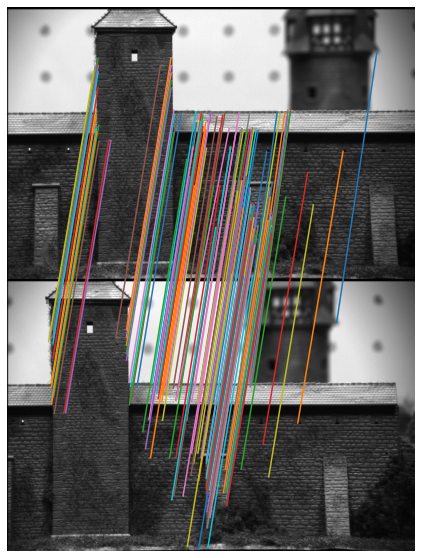

In [10]:
# Find matches
print('Finding matches for Cast')
radius = 50
threshold = 0.99
cast_matches = []
for i in range(len(cast_images) - 1):
    im1, corner_mask_1 = cast_images[i], cast_corner_masks[i]
    im2, corner_mask_2 = cast_images[i + 1], cast_corner_masks[i + 1]
    matches = patch2patch(im1, im2, corner_mask_1, corner_mask_2, radius)
    print(f"{len(matches)} matches found.")
    pruned_matches = prune_matches(matches, threshold)
    print(f"{len(pruned_matches)} were selected.")
    if len(pruned_matches) != 0:
        drawLines(im1.cpu().numpy(), im2.cpu().numpy(), pruned_matches)
    cast_matches.append(pruned_matches)

### Feature Matching for Cone

Finding matches for Cone
346 matches found.
64 were selected.


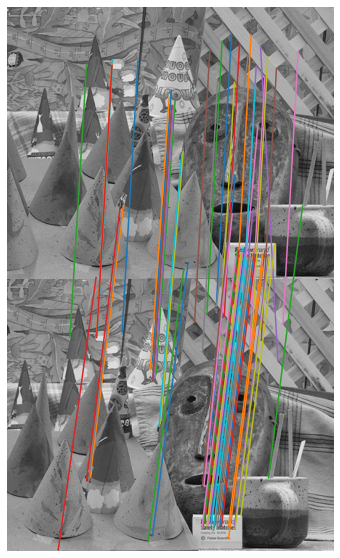

In [11]:
# Find matches
print('Finding matches for Cone')
radius = 30
threshold = 0.99
cone_matches = []
for i in range(len(cones_images) - 1):
    im1, corner_mask_1 = cones_images[i], cones_corner_masks[i]
    im2, corner_mask_2 = cones_images[i + 1], cones_corner_masks[i + 1]
    matches = patch2patch(im1, im2, corner_mask_1, corner_mask_2, radius)
    print(f"{len(matches)} matches found.")
    pruned_matches = prune_matches(matches, threshold)
    print(f"{len(pruned_matches)} were selected.")
    if len(pruned_matches) != 0:
        drawLines(im1.cpu().numpy(), im2.cpu().numpy(), pruned_matches)
    cone_matches.append(pruned_matches)

### Fundamental Calculation Function + RANSAC

In [12]:
def calculate_fundamental_matrix(matches, device):
    A = []
    for match in matches:
        if isinstance(match, np.ndarray):
            match = torch.from_numpy(match)
        x = match[1].item()
        y = match[0].item()
        x_p = match[3].item()
        y_p = match[2].item()
        A.append([x * x_p, x * y_p, x, y * x_p, y * y_p, y, x_p, y_p, 1])

    A = torch.tensor(A).to(device)
    u, s, v = torch.linalg.svd(A)
    # Extract the minimum eigenvalue and normalize
    h = v[8].reshape(3, 3)
    # Enforce singularity constraint
    U, S, V = h.svd()
    S[-1] = 0
    h = U.mm(S * torch.eye(len(S))).mm(V.T)
    # Enforce unit norm constraint
    h = h / h.norm()
    return h

def line_check(match, f):
    p_1 = torch.tensor([[match[1], match[0], 1]]).T
    p_2 = torch.tensor([[match[3], match[2], 1]])
    return torch.abs(p_2.mm(f).mm(p_1)).item()


def ransac(matches, num_trials, thres=5, device='cpu'):
    max_inliers = []
    best_f = torch.empty(0)
    iterator = tqdm.tqdm(range(num_trials))
    for i in iterator:
        rng = np.random.default_rng()
        eight_random_idx = rng.choice(len(matches), 8, replace=False)
        eight_random_pts = torch.vstack([matches[idx] for idx in eight_random_idx])
        f = calculate_fundamental_matrix(eight_random_pts, device)
        curr_inliers = []
        for match in matches:
            if line_check(match, f) < thres:
                curr_inliers.append(match)
        
        if len(curr_inliers) > len(max_inliers):
            max_inliers = curr_inliers
            best_f = f
        iterator.set_postfix_str(f"Max inliers: {len(max_inliers)}, Current inliers: {len(curr_inliers)}")
    return best_f, torch.vstack(max_inliers)


### Fundamental Matrix Calculation for Cast

In [13]:
f_matrix_cast = []
num_trials = 5000
thres = 0.001
for match in cast_matches:
    _, inliers = ransac(match, num_trials, thres=thres)
    f = calculate_fundamental_matrix(inliers, 'cpu') if len(inliers) != 0 else None
    f_matrix_cast.append(f)
print(f_matrix_cast)

100%|██████████| 5000/5000 [01:48<00:00, 45.94it/s, Max inliers: 123, Current inliers: 0]  


[tensor([[-1.0808e-14, -1.5747e-07,  2.8935e-08],
        [-1.3726e-10,  5.9605e-08, -7.0711e-01],
        [ 4.8558e-08,  7.0711e-01,  4.0829e-06]])]


### Fundamental Matrix Calculation for Cone

In [14]:
f_matrix_cones = []
num_trials = 5000
thres = 0.001
for match in cone_matches:
    _, inliers = ransac(match, num_trials, thres=thres)
    f = calculate_fundamental_matrix(inliers, 'cpu')
    f_matrix_cones.append(f)
print(f_matrix_cones)

100%|██████████| 5000/5000 [01:04<00:00, 76.99it/s, Max inliers: 61, Current inliers: 0]  

[tensor([[-1.8716e-14,  1.2038e-07,  2.4239e-07],
        [ 3.4155e-09,  8.9407e-08, -7.0711e-01],
        [-1.0306e-07,  7.0711e-01, -1.8775e-06]])]


### Constrained Dense Disparity Map Search

In [15]:
# def disparity_map(images, f, patch_rad):
#     r, c = images[1].shape
#     dis_map_x = torch.zeros([10, 10])
#     dis_map_y = torch.zeros([10, 10])
#     accuracy_map = torch.zeros([10, 10])
#     iterator = tqdm.tqdm(range(0, 10))
#     for i in iterator:
#         for j in range(0, 10):
#             source_pt = torch.tensor([[j, i, 1]]).float().T
#             dest_line = f.mm(source_pt)
#             best_match = 0
#             best_x, best_y = 0, 0
#             for y in range(0, 10):
#                 x = - int((dest_line[0] * y + dest_line[2]) / dest_line[1])
#                 iterator.set_postfix({"i": i, "j": j, "x": x, "y": y, "best_ncc": best_match})
#                 if 0 <= x < c:
#                     src_patch_slc = get_patch_rads(i, j, patch_rad, r, c)
#                     dest_patch_slc = get_patch_rads(y, x, patch_rad, r, c)
#                     patch_slc = [min(s, d) for s, d in zip(src_patch_slc, dest_patch_slc)]
#                     source_patch_slc = (slice(i - patch_slc[0], i + patch_slc[1]), slice(j - patch_slc[2], j + patch_slc[3]))
#                     dest_patch_slc = (slice(x - patch_slc[0], x + patch_slc[1]), slice(y - patch_slc[2], y + patch_slc[3]))
#                     source_patch = images[0][source_patch_slc]
#                     dest_patch = images[1][dest_patch_slc]
#                     print(dest_patch.shape, source_patch.shape)
#                     dist = patch_ncc(source_patch, dest_patch)
#                     if best_match < dist:
#                         best_match = dist
#                         best_x, best_y = [x, y]
#             dis_map_x[i, j] = best_x - i
#             dis_map_y[i, j] = best_y - j
#             accuracy_map[i, j] = best_match
#     return dis_map_x, dis_map_y, accuracy_map

### Disparity Map Calculation

### Visualization Functions

In [45]:
def vis_dist_map_single_axis(img, dist_map):
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    if isinstance(dist_map, torch.Tensor):
        dist_map = dist_map.cpu().numpy()
    plt.imshow(img, cmap='gray')
    max_dim = max(*img.shape)
    dist_im_plt = plt.imshow(dist_map, cmap='jet', vmin=-max_dim, vmax=max_dim, alpha=0.5)
    plt.colorbar(dist_im_plt)
    plt.show()

def make_colorwheel():
    """
    Code from https://github.com/princeton-vl/RAFT/
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    Code follows the original C++ source code of Daniel Scharstein.
    Code follows the the Matlab source code of Deqing Sun.
    Returns:
        np.ndarray: Color wheel
    """

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_uv_to_colors(u, v, convert_to_bgr=False):
    """
    Code from https://github.com/princeton-vl/RAFT/
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    Args:
        u (np.ndarray): Input horizontal flow of shape [H,W]
        v (np.ndarray): Input vertical flow of shape [H,W]
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.
    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)
    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]
    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi
    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0
    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1
        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range
        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)
    return flow_image


def flow_to_image(flow_uv, clip_flow=None, convert_to_bgr=False):
    """
    Expects a two dimensional flow image of shape.
    Args:
        flow_uv (np.ndarray): Flow UV image of shape [H,W,2]
        clip_flow (float, optional): Clip maximum of flow values. Defaults to None.
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.
    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'
    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)
    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]
    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)
    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)
    return flow_uv_to_colors(u, v, convert_to_bgr)

def viz_disparity_hsv(img, disp_map):
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    if isinstance(disp_map, torch.Tensor):
        disp_map = disp_map.cpu().numpy()
    plt.imshow(img, cmap='gray')
    max_dim = max(*img.shape)
    dist_im_plt = plt.imshow(flow_to_image(disp_map), alpha=0.5)
    print(flow_to_image(disp_map).mean())
    plt.colorbar(dist_im_plt)
    plt.show()

### Disparity Map Calculation for Cast

In [17]:
cast_dist_map, cast_dist_map_accuracy, cast_dense_matches = disparity_map(cast_images[0],
                                                                          cast_images[1],
                                                                          f_matrix_cast[0].cuda(), 100)

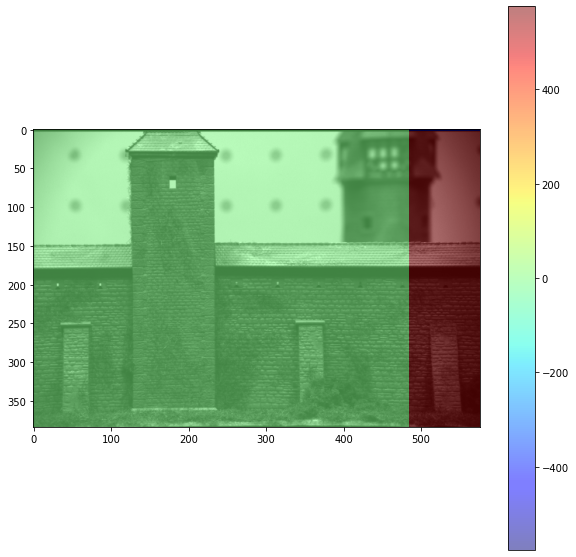

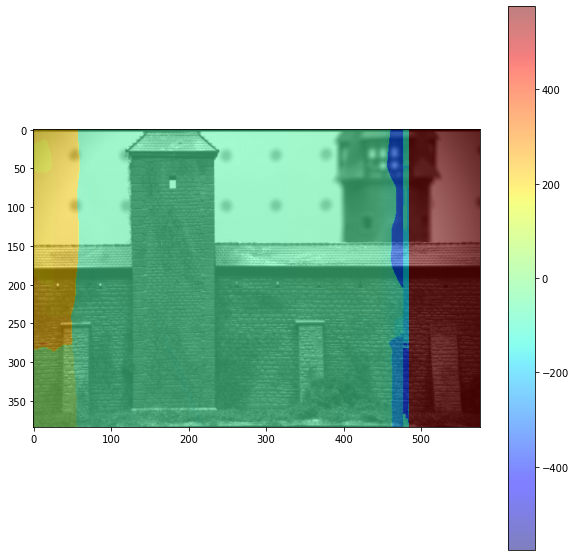

233.56199966242283


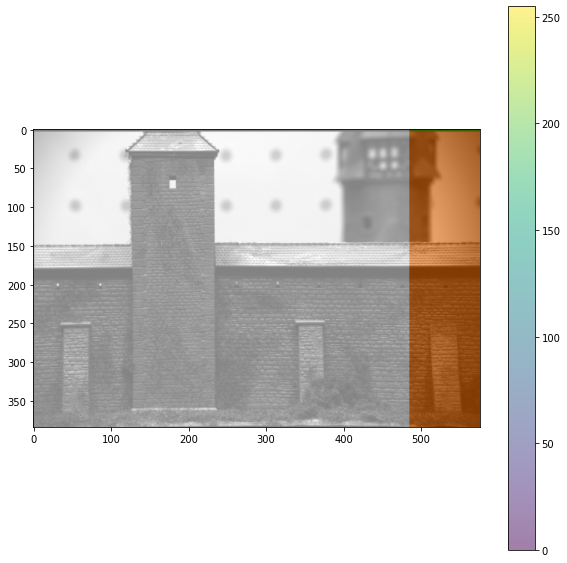

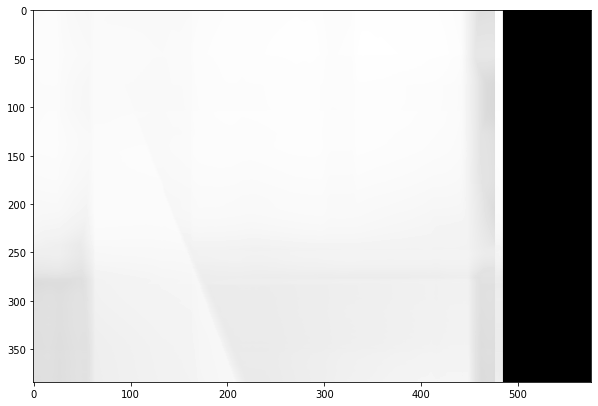

tensor(-41.2826, device='cuda:0')


In [50]:
vis_dist_map_single_axis(cast_images[0], cast_dist_map[:, :, 0])
vis_dist_map_single_axis(cast_images[0], cast_dist_map[:, :, 1])
viz_disparity_hsv(cast_images[0], cast_dist_map)
plt.imshow(cast_dist_map_accuracy.cpu().numpy(), vmin=0, vmax=1, cmap='gray')
plt.show()
print(cast_dist_map[:, :-100, 1].mean())

### Disparity Map Calculation for Cones

In [19]:
cone_dist_map, cone_dist_map_accuracy, cone_dense_matches = disparity_map(cones_images[0],
                                                                          cones_images[1],
                                                                          f_matrix_cones[0].cuda(), 100)


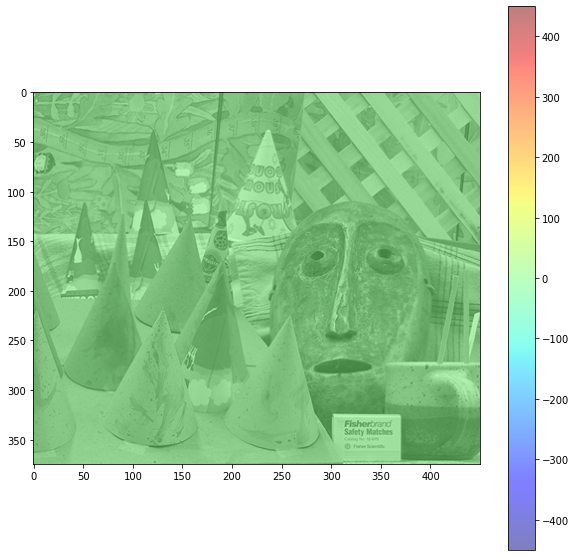

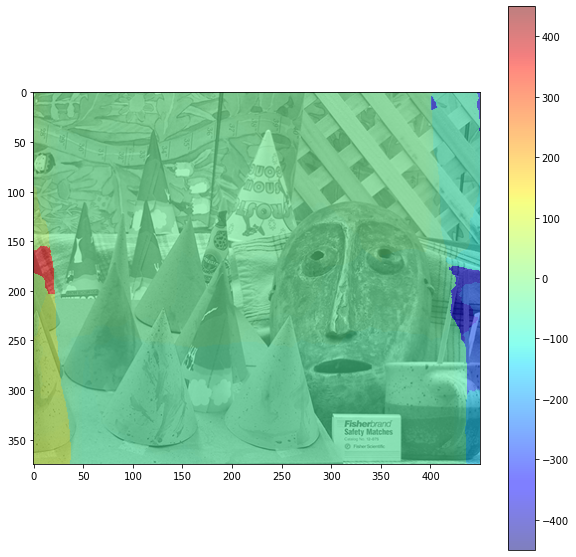

243.61413530864198


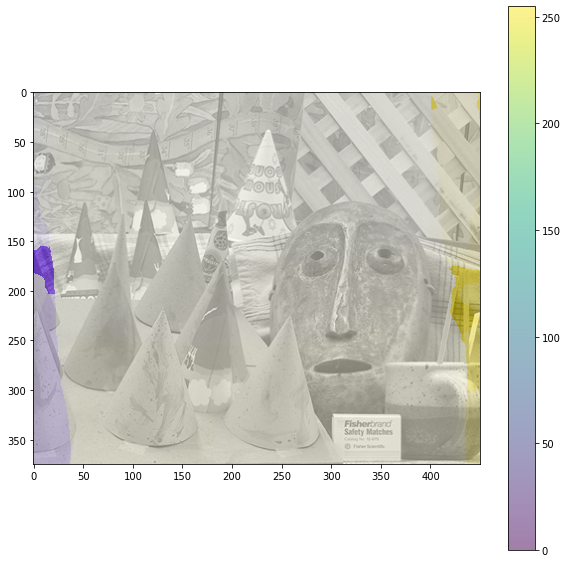

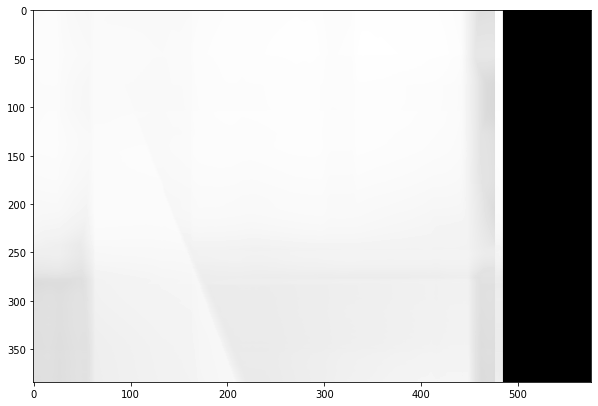

tensor(-34.9858, device='cuda:0')


In [46]:
vis_dist_map_single_axis(cones_images[0], cone_dist_map[:, :, 0])
vis_dist_map_single_axis(cones_images[0], cone_dist_map[:, :, 1])
viz_disparity_hsv(cones_images[0], -cone_dist_map)
plt.imshow(cast_dist_map_accuracy.cpu().numpy(), vmin=0, vmax=1, cmap='gray')
plt.show()
print(cone_dist_map[:, :, 1].mean())